### <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 3 - Parte 2  </H3>
<hr style="height:2px;border:none"/>

**Integrantes**  
* Rodrigo Hermosilla
* Eliana Providel
* Sebastián Rodriguez

<a id="segundo"></a>
## 2. Clasificación con clases desbalanceadas

En las tareas de clasificación supervisada, buscamos que mediante los ejemplos etiquetados la maquina pueda aprender los atributos inerentes a las distintas clases. Sin embargo, en muchos casos reales de clasificación, la cantidad de ejemplos de cada clase son muy dispares, en cuyo caso hablamos de clases desbalanceadas. Si uno no aplica estrategias para compensar este problema, la maquina aprenderá muy bien las caracteristicas de la clase más representada pero no logrará extraer información generalizable de la clase menos representada. Además, debemos tener cuidado al momento de interpretar las distintas métricas a las cuales tenemos acceso, pues debemos tomar en cuenta el balance de las clases y la naturaleza del problema para evaluar realmente que tan bueno es el desempeño. 



Para esta parte de la tarea utilizaremos el siguiente _dataset_ publicado en Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud. Este conjunto de datos contiene unos 285000 ejemplos de transacciones con tarjetas de crédito reales, realizadas en 2013 por clientes europeos. Los datos son totalmente anónimos y son el resultado de un PCA a partir de los datos originales excepto por las columnas `Time` con el tiempo en segundos desde la primera transacción, `Amount` con el monto de la transacción y `Class` que indica si la transacción es fraudulenta o no. La tarea en cuestión consiste en lograr predecir cuando una transacción es fraudulenta o no automaticamente, para así poder detenerla antes de que se termine. Sin embargo, por la naturaleza de las transacciones bancarias, este problema es desbalanceado, de hecho de los 285000 transacciones registradas, solo 492 son fraudulentas! A lo largo de esta pregunta pondremos en evidencia los problemas que se originan de este desbalance de clases y trataremos de dar luces a algunas herramientas que nos permitan sortear esos problemas y como medir realmente el desempeño en esta clase de problemas. 

In [1]:
#!unzip creditcardfraud.zip

#### 2.a Carga de datos
Descargue los datos y cárguelos usando pandas. Haga una exploración rápida de los datos, cuantos datos hay, como se reparten sus valores.

Grafique la matriz de correlación, a primera vista parece relevante mantener la columna `Time`? En su opinión, conociendo la naturaleza del problema le parece relevante esa información para predecir el _target_?

Cuantos ejemplos hay de cada clase? Son las clases desbalanceadas efectivamente? 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report

sns.set()
%matplotlib inline

In [3]:
df = pd.read_csv('creditcard.csv')
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Comentarios:** 

Podemos observar que no hay datos faltantes a través del dataset mediante el siguiente método.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


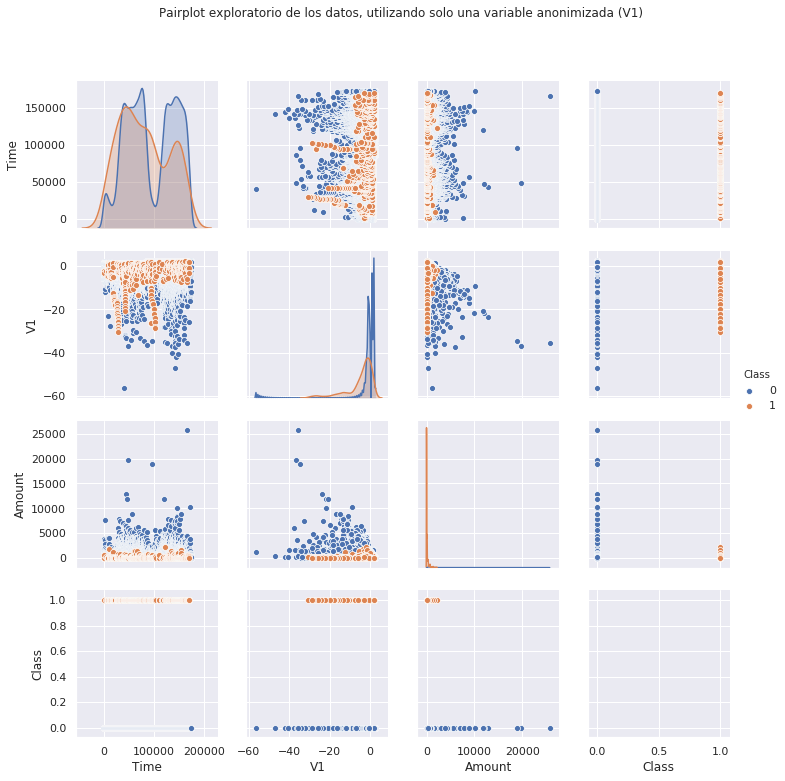

In [5]:
ax = sns.pairplot(df[df.columns[[0,1,-2,-1]]],hue="Class", )

ax.fig.suptitle("Pairplot exploratorio de los datos, utilizando solo una variable anonimizada (V1)",y=1.08)
plt.show()

> Cuantos ejemplos hay de cada clase? Son las clases desbalanceadas efectivamente? 

Clase 0: 284315 registros
Clase 1: 492 registros


Text(0.5, 1.0, 'Cantidad de muestras por categoria')

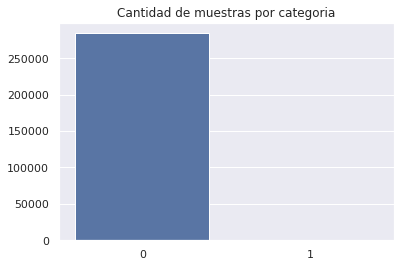

In [6]:
c, n = np.unique(df.Class,return_counts=True)
print("Clase {}: {} registros".format(c[0], n[0]))
print("Clase {}: {} registros".format(c[1], n[1]))

ax = sns.barplot(x = c, y = n)
ax.set_title("Cantidad de muestras por categoria")

> Grafique la matriz de correlación, a primera vista parece relevante mantener la columna `Time`?  

A primera vista, si. Esto es debido a que caracteristicas independientes unas con otras, aportan mayor información para la clasificación (o regresión). Como puede observar, la columna `Time` tiene baja correlación **lineal** con las otras caracteristicas, a excepcion de `V3` con un valor de $-0.42$.

> En su opinión, conociendo la naturaleza del problema le parece relevante esa información para predecir el _target_?

En el caso de que nosotros pudiesemos saber el significado de las caracteristicas y pudiesemos saber si por ejemplo:

- Dos o mas fraudes ocurren en tiempos cercanos
- Son al mismo cliente o mismo banco
- A que pais se realizo la transacción versus el pais de origen del banco
- A que hora se realiza la transacción
- Monto

Como nosotros estamos enfrentando un problema donde las caracteristicas estan **anonimizadas** utilizando PCA, existe la transformación sin posibilidad de recuperación de las estructuras originales. Por lo mismo, solo podemos esperar que esta transformación mantenga la naturaleza del problema como tal. Entonces utilizando esta transformación, nos atreveriamos a decir que el tiempo **NO** nos aporta informacion relevante ya que perdimos la estructura original. Ademas de que dada la estructura misma de la columna `Time`, esto puede verse como un identificador, debido a que es un correlativo (con respecto a tiempo 0).



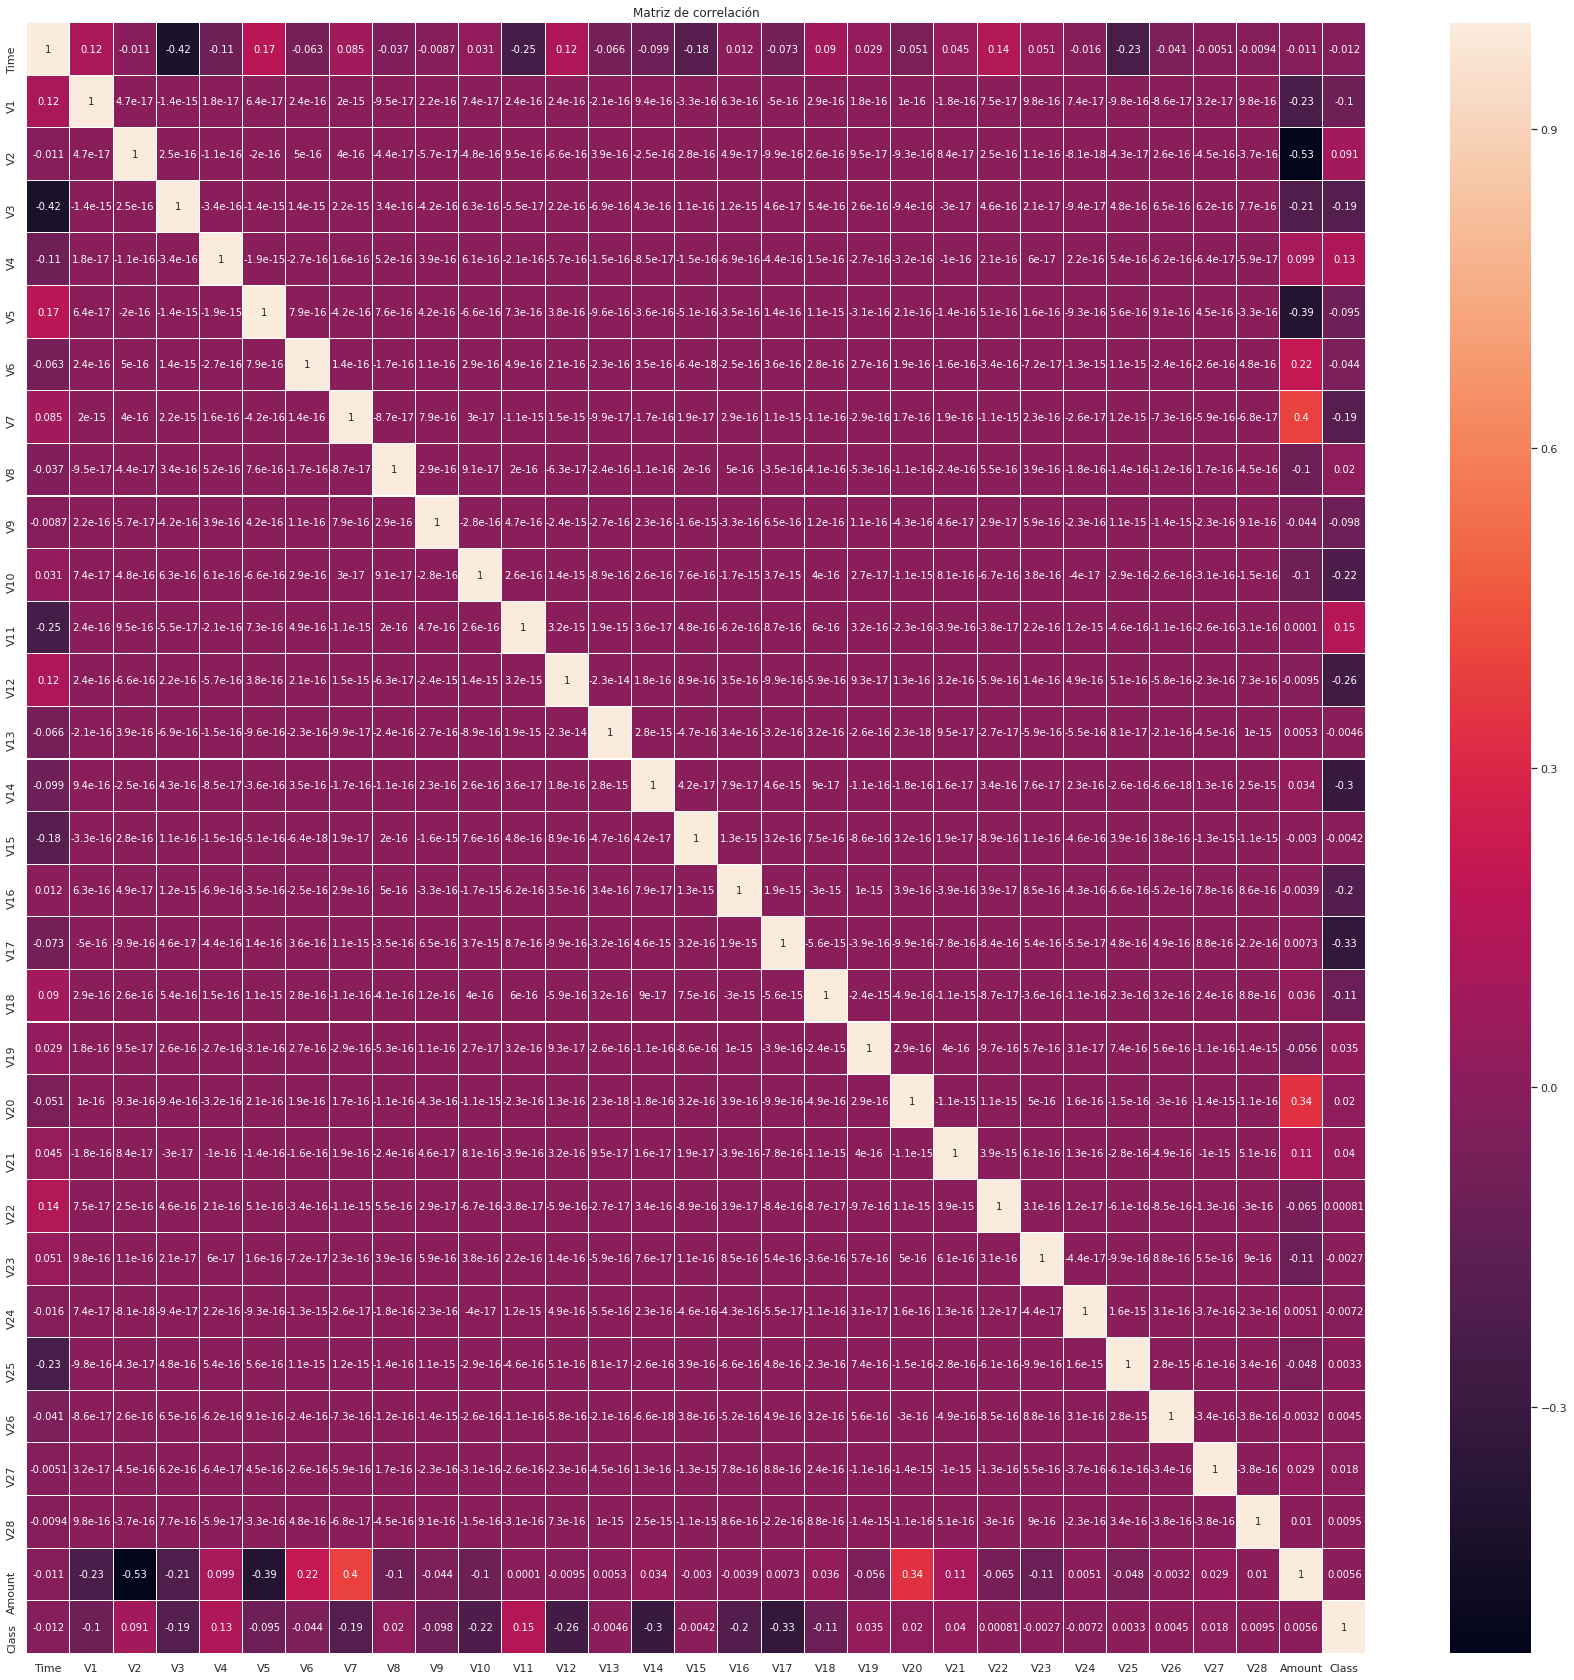

In [7]:
fig = plt.figure(figsize=(30,30))
ax = sns.heatmap(df.corr(), annot=True,linewidths=0.1)

ax.set_title("Matriz de correlación")
plt.show()

#### 2.b Ligero preprocesamiento

> * Escale la columna `Amount`. Por qué es aconsejable realizar esto? Le parece necesario realizarlo en el resto de las columnas? 

Por que respecto a la escala en la que estan las otras caracteristicas, es la unica que se aleja completamente desde la distribucion del resto de los datos.

> * Separe los atributos del _target_.

> * Separe luego los datos en _Training set_ y _Validation set_, con un 20% de los datos como validación y el resto como _train_. Asegurese que se mantienen las proporciones de ejemplos de cada clase en ambos sets. 

> * Qué ocurriría si por ejemplo todos los ejemplos de la clase 1 quedaran en el _validation set_, que haría cualquier máquina de aprendizaje al aprender solo con la clase 0?

No podria aprender, dado que solo conoce una clase (la clase 0). A modo de ejemplo, un metodo como las SVM, no podrian generar un hiperplano separador entre clases (solo hay 1).

En el caso de Scikit-learn, deberia tirar un exception de que solo existe una clase en el set a entrenar.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df['Amount'].values.reshape(-1,1))
df['Amount'] = scaler.transform(df['Amount'].values.reshape(-1,1))  # Escalamos los datos de amount
print("Caracteristicas utilizadas: {}".format(df.columns[0:-1])) #Presentamos las caracteristicas a utilizar
print("======")
x = df[df.columns[1:-1]] #Generamos los X
y = df.Class # obtenemos los Y

from sklearn.model_selection import train_test_split

#Debido al desbalance de los datos, nosotros tenemos que hacer el split mediante la estratificación
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.8, random_state = 42, stratify = y) 

#Verificamos proporciones de los datos
y_counts = y.value_counts(normalize=True)
y_train_counts = y_train.value_counts(normalize=True)
y_val_counts = y_val.value_counts(normalize=True)

print("Porcentaje total, \t\t categoria 0: {:.5f}%; categoria 1: {:.5f}%".format(y_counts[0]*100, y_counts[1]*100))
print("Porcentaje en train, \t\t categoria 0: {:.5f}%; categoria 1: {:.5f}%".format(y_train_counts[0]*100, y_train_counts[1]*100))
print("Porcentaje en validación: \t categoria 0: {:.5f}%; categoria 1: {:.5f}%".format(y_val_counts[0]*100, y_val_counts[1]*100))

Caracteristicas utilizadas: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
Porcentaje total, 		 categoria 0: 99.82725%; categoria 1: 0.17275%
Porcentaje en train, 		 categoria 0: 99.82708%; categoria 1: 0.17292%
Porcentaje en validación: 	 categoria 0: 99.82796%; categoria 1: 0.17204%


#### 2.c Regresor logístico

Entrene un regresor logístico con los datos obtenidos de la pregunta anterior y calcule su desempeño (_score_ por ahora) sobre los datos de validación. A priori le parece un buen desempeño? 

In [9]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression()
logistic_clf.fit(x_train,y_train)
accuracy = logistic_clf.score(x_val,y_val)
print(accuracy)

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9991573329588147


> Entrene un regresor logístico con los datos obtenidos de la pregunta anterior y calcule su desempeño (_score_ por ahora) sobre los datos de validación. A priori le parece un buen desempeño? 

Si no estuviesen desbalanceados los datos, seria un desempeño excepcional. Como este no es el caso, hay que ver el comportamiento del clasificador no solo en terminos de exactitud (accuracy), sino tambien utilizando otras metricas que puedan dar cuenta de como es el rendimiento del algoritmo por clase (ver la exactitud de la clase 0 y la clase 1 por ejemplo).

In [10]:
pred = logistic_clf.predict(x_val)
print(classification_report(y_val,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



Dado que ahora tenemos mayor información, podemos ver que la regresión logística tiene un buen rendimiento base para realizar comparaciones ( puntaje f1 de 0.72). Mas adelante vamos a ver la matriz de confusión como metodo alternativo para evaluar el rendimiento.

#### 2.d _Always_ 0

Suponga un modelo le entrega como resultado en el conjunto de validación el siguiente `y_pred`. ¿Qué está haciendo este predictor? ¿Qué _score_ obtendría tal modelo sobre el conjunto de validación? ¿Le parece que el modelo tenga un buen desempeño? Concluya sobre la calidad del _accuracy_ que obtenemos con `.score` para evaluar el desempeño de estos modelos. 

In [11]:
from sklearn.metrics import accuracy_score
y_pred = pd.np.zeros(y_val.shape)
acc0 = accuracy_score(y_val,y_pred)
print(acc0)

0.9982795547909132


> ¿Qué está haciendo este predictor? 

No fue capaz de modelar las distintas clases, ya que solo reconoce una de estas (la clase 0)

>¿Qué _score_ obtendría tal modelo sobre el conjunto de validación? 

El score que este obtendria seria una exactitud de 99.828% aproximadamente, la cual corresponde al porcentaje de elementos 0 en el conjunto de validación (obtendria la proporcion de ceros en el conjunto de validación).


>¿Le parece que el modelo tenga un buen desempeño? Concluya sobre la calidad del _accuracy_ que obtenemos con `.score` para evaluar el desempeño de estos modelos. 

En este caso, el modelo no tiene un buen desempeño ya que es incapaz de reconocer la clase 1. Dependiendo del problema esto puede ser algo critico, ya que el enfoque por lo general corresponde a detectar la categoria desbalanceada (en esta caso si la transacción es fraudulenta). Otro ejemplo de problema que se enfoca en la clase minoritaria, corresponde a problemas del area de la salud, donde la mayoria de las personas estan sanas, y queremos detectar personas enfermas. Si nuestro modelo solo reconoce gente sana, estamos condenando a la gente enferma.

Tal como dijimos anteriormente, solo la exactitud para evaluar problemas de clasificación puede presentar problemas al momento de hacer la evaluación del modelo, por lo que necesitamos otras metricas para medir el rendimiento, sobre todo en problemas desbalanceados. 

#### 2.e Matriz de confusión

> Investigue un poco sobre los valores que conforman la matriz de confusión o _confusion matrix_. Comente sobre la significancia de los distintos valores para el problema en cuestión. 

![](matriz_confusion.png)


donde:

- vp: corresponde a la cantidad de positivos que fueron clasificados correctamente como positivos por el modelo
- vn: es la cantidad de negativos que fueron clasificados correctamente como negativos por el modelo
- fn: es la cantidad de positivos que fueron clasificados incorrectamente como negativos
- fp: es la cantidad de negativos que fueron clasificados incorrectamente como positivos

Dado el problema, los valores de $fn$ y $fp$ pueden ser criticos al momento de evaluar el modelo. En el caso de fraude de tarjetas de credito, los falsos negativos son de nuestro interes (debido a que es un fraude que no se esta reconociendo). En el caso de los falsos positivos, lo peor que puede pasar es que una compra no se lleve a cabo. 

>Escriba una función que a partir de un modelo o de los valores predecidos por un modelo, grafique la matriz de confusión. 

In [12]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(x_toplot, y_toplot ,model = None, predicted_vals = None, scale = True, ax = None):    
    if predicted_vals is not None:
        norm = len(predicted_vals) if scale else 1
        ax = sns.heatmap(confusion_matrix(y_toplot, predicted_vals)/norm,cmap='winter', annot=True, ax = ax)    
        ax.set_xlabel("valores predecidos")
        ax.set_ylabel("valores actuales")
        return ax
    else:
        assert model
        norm = len(x_toplot) if scale else 1
        ax = sns.heatmap(confusion_matrix(y_toplot, model.predict(x_toplot))/norm,cmap='winter', annot=True, ax = ax)
        ax.set_xlabel("valores predecidos")
        ax.set_ylabel("valores actuales")
        return ax

>Grafique la matriz de confusión para la regresión logística realizada en el punto c y para los valores `y_pred` del punto d. Le parecen parecidos ahora ambos modelos? 

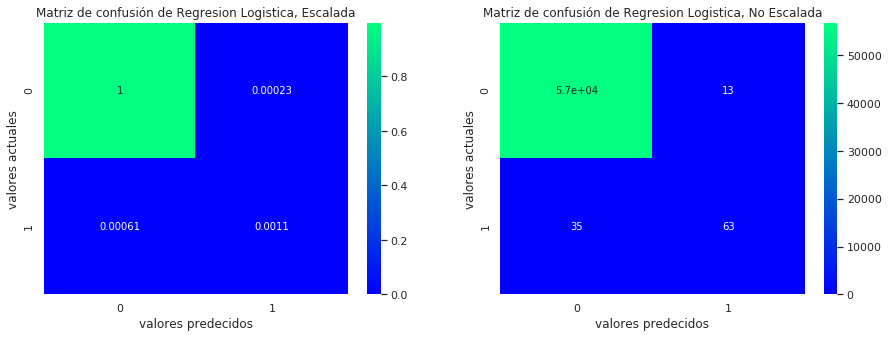

In [13]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

plot_confusion_matrix(x_val, y_val, model=logistic_clf, scale = True,ax = axes[0])
axes[0].set_title("Matriz de confusión de {}, {}".format("Regresion Logistica","Escalada"))
plot_confusion_matrix(x_val, y_val, model=logistic_clf, scale = False,ax = axes[1])
axes[1].set_title("Matriz de confusión de {}, {}".format("Regresion Logistica","No Escalada"))
plt.show()

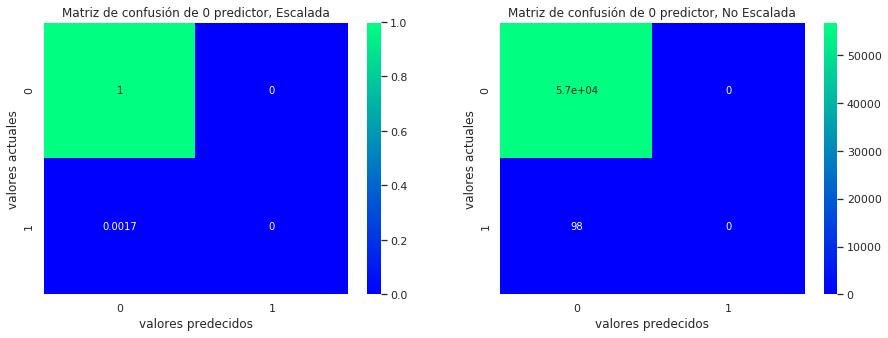

In [14]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_confusion_matrix(x_val, y_val, predicted_vals=y_pred, scale = True,ax = axes[0])
axes[0].set_title("Matriz de confusión de {}, {}".format("0 predictor","Escalada"))
plot_confusion_matrix(x_val, y_val, predicted_vals=y_pred, scale = False,ax = axes[1])
axes[1].set_title("Matriz de confusión de {}, {}".format("0 predictor","No Escalada"))
plt.show()

> Le parecen parecidos ahora ambos modelos? 

Claramente despues de ver las matrices de confusion, podemos observar el problema de que la regresion logistica si logra detectar un porcentaje no menor (63 de 98 casos de fraude), a diferencia de del modelo teorico, que no es capaz de reconocer la clase 1.

#### 2.f Curva ROC
>La curva ROC tiene bastante utilidad para evaluar la calidad de distintos modelos en estos casos. Investigue un poco sobre su significado para poder interpretarla correctamente y luego escriba una función que reciba un modelo entrenado y la grafíque. 


**Acerca de la curva ROC:**

Una curva ROC (curva de Receiver Operating Characteristic) son curvas en las que se presenta la sensibilidad (Proporcion de verdaderos positivos), en funcion de la proporción de falsos positivos (1-especificidad).

![](ROC.jpg)

Esta representacion es util ya que con el area bajo podemos analizar el rendimiento del modelo (con 1, siendo el mejor performance y 0.5 un mal performance para clasificación binaria). Aparte de esto, nos permite seleccionar puntos de corte, en donde estamos dispuestos dado el problema, tener una mayor cantidad de falsos positivos dado los verdaderos positivos.

$$Sensitividad = \frac{VP}{(VP + FN)}$$

$$Especificidad = \frac{VN}{(VN + FP)}$$

$$TPR = Sensitividad$$
$$FPR = 1 - Especificidad$$
>Note que `sklearn` trae implementado una función que entrega los puntos de la curva ROC, note eso sí que debe entregarle las probabilidades usando el método `predict_proba` del modelo entrenado. 

>Para evaluar distintos modelos utilizará bastante las curvas ROC y la matriz de confusión, por lo que sería recomendable escribir una función que reciba un modelo y datos y realice tanto la curva ROC como la matriz de confusión, aunque escribir tal función no es requisito. 

In [15]:
from sklearn.metrics import roc_curve

def plot_roc_curve(t_set,model,title="ROC", label = "model"):
    x_s, y_s = t_set
    #x_vl, y_vl = val_set
    fpr, tpr, _ = roc_curve(y_s, model.predict_proba(x_s)[:,1],pos_label=1)
    plt.plot(fpr, tpr, label = label )

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    
def plot_roc_curve_zoomed(t_set,model,title="ROC", label = "model",y_start = 0.8, x_end = 0.2):
    plt.xlim(-0.05, x_end)
    plt.ylim(y_start, 1)
    x_s, y_s = t_set
    #x_vl, y_vl = val_set
    fpr, tpr, _ = roc_curve(y_s, model.predict_proba(x_s)[:,1],pos_label=1)
    plt.plot(fpr, tpr, label = label )

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()

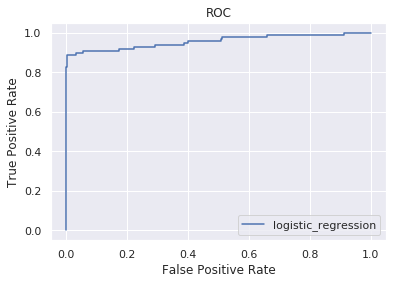

In [16]:
plot_roc_curve(t_set=(x_val,y_val), model=logistic_clf,title="ROC",label="logistic_regression")

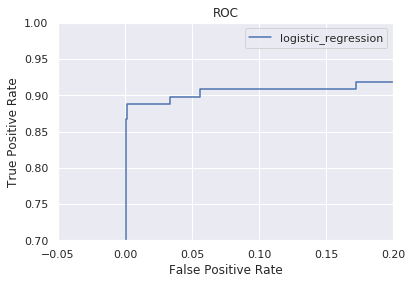

In [17]:
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=logistic_clf, 
                      title="ROC",
                      label="logistic_regression",
                      y_start=0.7
                     )

>Utilice la función definida para su modelo de regresión logística. Comente el gráfico obtenido.

Podemos observar que como punto de partida, la regresion logística obtiene un ratio de verdaderos positivos bastante bueno, cercano a 0.87 (como se puede ver en la curva ROC con zoom). Si fuese un análisis simple y no nos importaran los falsos positivos, podriamos decir que con un FPR de 0.9 aproximadamente, podriamos evitar tener falsos negativos.

El problema que eso conlleva es que tenemos un gran porcentaje de muestras negativas que quedarían mal clasificadas (sería equivalente a decir a un modelo que dice que todo es 1), entonces nuestro análisis se enfocará en que tan rápido llega a un TPR de 1 y cuál es el punto de partida de TPR. En este caso para la regresión logística el punto de partida es bastante bueno, cercano a los 0.87, se puede ver que en la matriz de confusión, una minoría es la más difícil de clasificar. Respecto a que tan rápido llega el TPR a 1 podemos ver que es casí líneal, y que compromete una gran parte de falsos positivos para obtener una buena clasificación de falsos positivos.

#### 2.g Arbol de Clasificación
> Entrene un arbol de clasificación para tratar de resolver el problema. Pruebe unas cuantas profundidades máximas distintas y elija una. Si quiere puede modificar los otros hiperparámetros del modelo. 

> Evalúe su desempeño respecto a los modelos lineales usando las métricas relevantes y compare su costo computacional. Discuta.

In [18]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(
            criterion='gini',
            #min_samples_leaf=15
            max_depth=3
)

tree_1 = DecisionTreeClassifier(
            criterion='gini',
            #min_samples_leaf=15
            max_depth=10
)

tree_2 = DecisionTreeClassifier(
            criterion='gini',
            #min_samples_leaf=15
            max_depth=20
)

tree_3 = DecisionTreeClassifier(
            criterion='gini',
            #min_samples_leaf=15
            max_depth=30
)

tree_4 = DecisionTreeClassifier(
            criterion='gini',
            #min_samples_leaf=15
            max_depth=100
)

tree.fit(x_train,y_train)
tree_score = tree.score(x_val,y_val)
print("Tree Score 0:   ", tree_score)

tree_1.fit(x_train,y_train)
tree_score_1 = tree_1.score(x_val,y_val)
print("Tree Score 1: ", tree_score_1)

tree_2.fit(x_train,y_train)
tree_score_2 = tree_2.score(x_val,y_val)
print("Tree Score 2: ", tree_score_2)

tree_3.fit(x_train,y_train)
tree_score_3 = tree_3.score(x_val,y_val)
print("Tree Score 3: ", tree_score_3)

tree_4.fit(x_train,y_train)
tree_score_4 = tree_4.score(x_val,y_val)
print("Tree Score 4: ", tree_score_4)

Tree Score 0:    0.9992099996488887
Tree Score 1:  0.9994382219725431
Tree Score 2:  0.9992626663389628
Tree Score 3:  0.9992099996488887
Tree Score 4:  0.9992099996488887


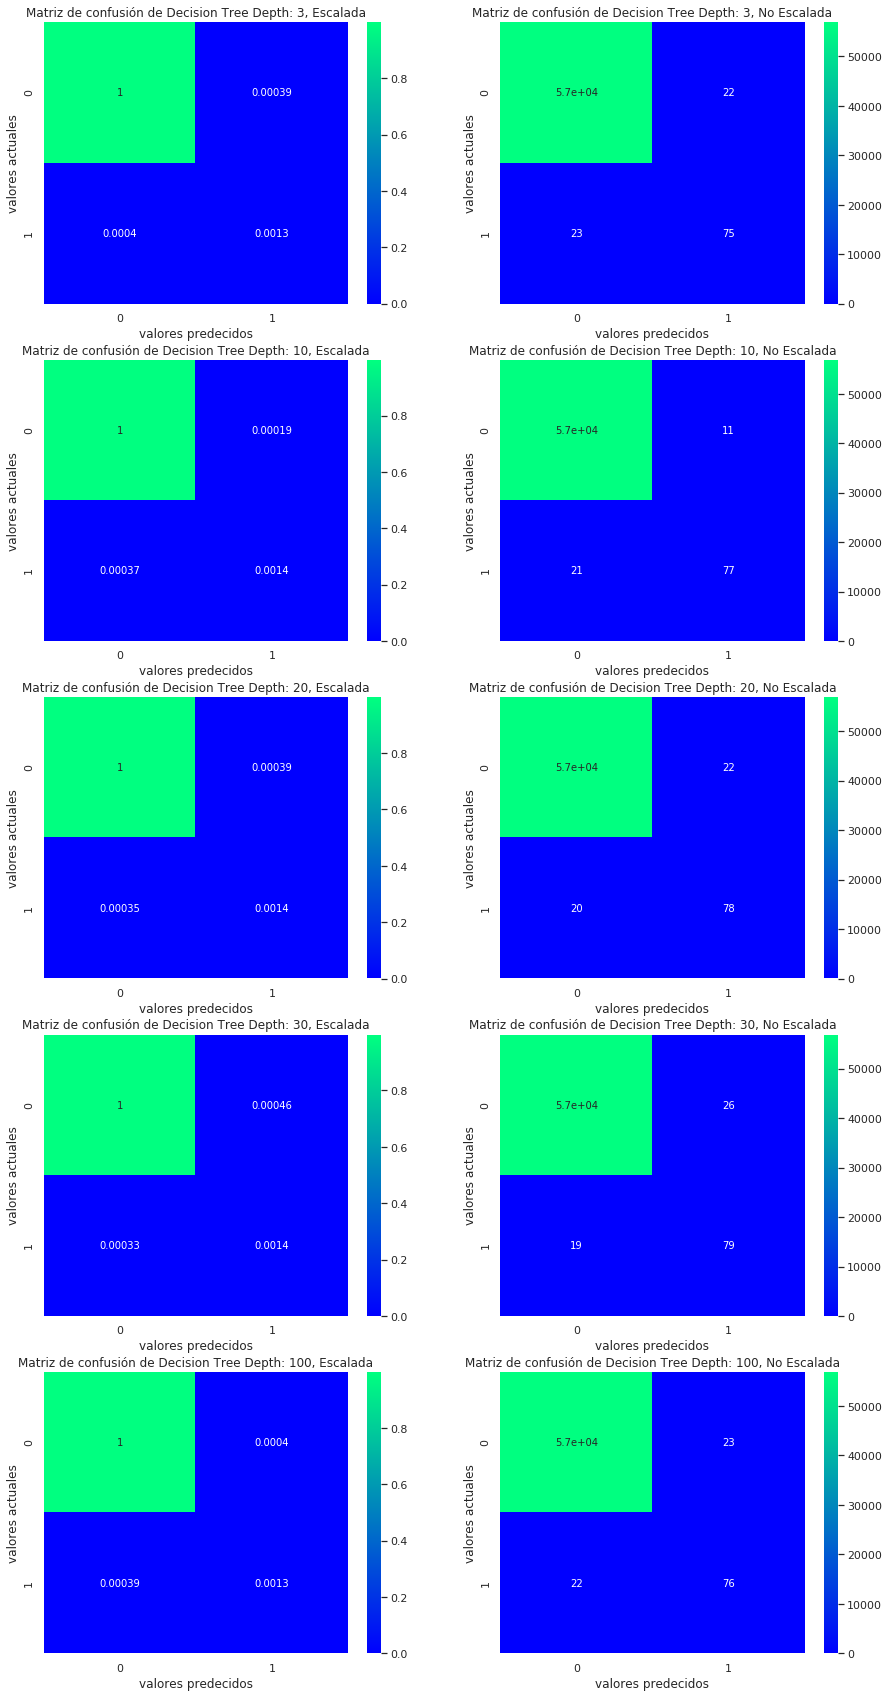

In [19]:
fig, axes = plt.subplots(5,2,figsize=(15,30))

plot_confusion_matrix(x_val, y_val, model=tree, scale = True,ax = axes[0][0])
axes[0][0].set_title("Matriz de confusión de {}, {}".format("Decision Tree Depth: 3","Escalada"))
plot_confusion_matrix(x_val, y_val, model=tree, scale = False,ax = axes[0][1])
axes[0][1].set_title("Matriz de confusión de {}, {}".format("Decision Tree Depth: 3","No Escalada"))

plot_confusion_matrix(x_val, y_val, model=tree_1, scale = True,ax = axes[1][0])
axes[1][0].set_title("Matriz de confusión de {}, {}".format("Decision Tree Depth: 10","Escalada"))
plot_confusion_matrix(x_val, y_val, model=tree_1, scale = False,ax = axes[1][1])
axes[1][1].set_title("Matriz de confusión de {}, {}".format("Decision Tree Depth: 10","No Escalada"))

plot_confusion_matrix(x_val, y_val, model=tree_2, scale = True,ax = axes[2][0])
axes[2][0].set_title("Matriz de confusión de {}, {}".format("Decision Tree Depth: 20","Escalada"))
plot_confusion_matrix(x_val, y_val, model=tree_2, scale = False,ax = axes[2][1])
axes[2][1].set_title("Matriz de confusión de {}, {}".format("Decision Tree Depth: 20","No Escalada"))

plot_confusion_matrix(x_val, y_val, model=tree_3, scale = True,ax = axes[3][0])
axes[3][0].set_title("Matriz de confusión de {}, {}".format("Decision Tree Depth: 30","Escalada"))
plot_confusion_matrix(x_val, y_val, model=tree_3, scale = False,ax = axes[3][1])
axes[3][1].set_title("Matriz de confusión de {}, {}".format("Decision Tree Depth: 30","No Escalada"))

plot_confusion_matrix(x_val, y_val, model=tree_4, scale = True,ax = axes[4][0])
axes[4][0].set_title("Matriz de confusión de {}, {}".format("Decision Tree Depth: 100","Escalada"))
plot_confusion_matrix(x_val, y_val, model=tree_4, scale = False,ax = axes[4][1])
axes[4][1].set_title("Matriz de confusión de {}, {}".format("Decision Tree Depth: 100","No Escalada"))


plt.show()

**Comentario:**

De acuerdo a la matrices de confusión obtenidas, el mejor rendimiento se observa en el árbol de profundidad 10, mientrás que  el árbol con profundidad 30 es que esta minimizando los falsos negativos en nuestro set de validación. Esto con el coste de aumentar los falsos positivos.

Otra observación que podemos obtener es que a mayor cantidad de profundidad se puede observar un mayor sobreajuste (que se puede corroborar con el valor de score obtenido), más aún un árbol de profundidad 100 tiene una mayor cantidad de falsos positivos y falsos negativos.  

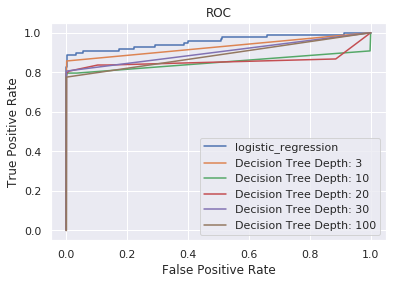

In [20]:
plot_roc_curve(t_set=(x_val,y_val), model=logistic_clf,title="ROC",label="logistic_regression")
plot_roc_curve((x_val,y_val),tree, label= "Decision Tree Depth: 3")
plot_roc_curve((x_val,y_val),tree_1, label= "Decision Tree Depth: 10")
plot_roc_curve((x_val,y_val),tree_2, label= "Decision Tree Depth: 20")
plot_roc_curve((x_val,y_val),tree_3, label= "Decision Tree Depth: 30")
plot_roc_curve((x_val,y_val),tree_4, label= "Decision Tree Depth: 100")

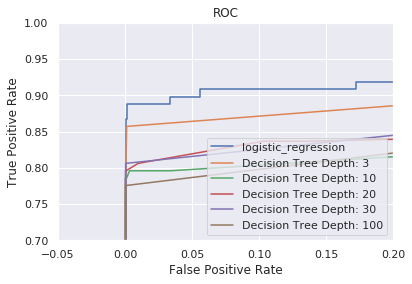

In [21]:
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=logistic_clf, 
                      title="ROC",
                      label="logistic_regression",
                      y_start=0.7
                     )
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree, 
                      title="ROC",
                      label="Decision Tree Depth: 3",
                      y_start=0.7
                     )
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree_1, 
                      title="ROC",
                      label="Decision Tree Depth: 10",
                      y_start=0.7
                     )

plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree_2, 
                      title="ROC",
                      label="Decision Tree Depth: 20",
                      y_start=0.7
                     )

plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree_3, 
                      title="ROC",
                      label="Decision Tree Depth: 30",
                      y_start=0.7
                     )

plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree_4, 
                      title="ROC",
                      label="Decision Tree Depth: 100",
                      y_start=0.7
                     )

**Comentario:**

Con las curvas ROC se puede observar que el mejor árbol es aquel que tiene menor profundidad, partiendo casí con 0.85 de TPR. Los otros árboles tienen un rendimiento de partida bajo al 0.80 lo que puede estar relacionado con un sobreajuste. Mas aún si bien el mejor puntaje es con profundidad 10, podemos ver que la matriz de confusión no clasifica mejor los falsos negativos si no mas bien los falsos positivos.

Finalmente, podemos observar que para todos los árboles existe una tendencia lineal siendolos árboles de profundidad  10 y 20 con el peor comportamiento.

#### 2.h _Undersampling_

> Considerando que la gran mayoría del aprendizaje se realiza en los ejemplos no fraudulentos, una aproximación para tratar de mejorar el desempeño de los modelos entrenados es simplemente reducir la cantidad de ejemplos de una clase para obtener nuevos conjuntos de datos con clases más balanceadas. Así, el aprendizaje se realiza de manera más balanceada entre ambas clases y se logran extraer mejor los atributos de cada clase. 

> Complete la siguiente función para que realice un _undersampling_ de la clase 0 para obtener una proporción en el nuevo conjundo de datos de `times` veces el numero de transacciones normales frente a fraudulentas. Comente sobre la decisión del parámetro `replace` de la función `numpy.random.choice`. 


> Note que la función recibe el _DataFrame_ con todos los datos. Se pide que retorne los conjuntos de _train_ y _validation_ para luego poder entrenar un modelo. 

In [22]:
def undersample(df, times = 10, validation_ratio = 0.2):
    fraud_indices = pd.np.array(df[df.Class==1].index)
    normal_indices = pd.np.array(df[df.Class==0].index)

    Count_Fraud_transaction = len(fraud_indices)
    np.random.RandomState(seed=42)
    Normal_indices_undersample = pd.np.array(
    pd.np.random.choice(
        normal_indices ,
        Count_Fraud_transaction * times, #times=1 --> len(x)==len(y), times=2 --> len(x)==2len(y), ...
        replace = False)
    )
    
    undersample_data = pd.np.concatenate([fraud_indices,Normal_indices_undersample])
    undersample_data = df.iloc[undersample_data]
    
    x = undersample_data[df.columns[1:-1]]
    y = undersample_data.Class
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = validation_ratio, random_state = 42, stratify = y)
    return x_train, y_train, x_val, y_val

def undersample_train_data(data = ([],[]), times = 10):
    x, y = data
    x = x.reset_index(drop=True)
    y = y.reset_index(drop=True)
    fraud_indices = np.array(x[y==1].index)
    normal_indices = np.array(x[y==0].index)
    
    Count_Fraud_transaction = len(fraud_indices)
    
    Normal_indices_undersample = pd.np.array(
    pd.np.random.choice(
        normal_indices ,
        Count_Fraud_transaction * times, #times=1 --> len(x)==len(y), times=2 --> len(x)==2len(y), ...
        replace = False)
    )
    undersample_data = pd.np.concatenate([fraud_indices,Normal_indices_undersample])
    #print(Normal_indices_undersample,len(Normal_indices_undersample))
    x_sampled = x.iloc[undersample_data]
    y_sampled = y.iloc[undersample_data]
    return x_sampled, y_sampled

> Comente sobre la decisión del parámetro `replace` de la función `numpy.random.choice`. 

**Comentario:**

El parámetro `replace`  permite aceptar o rechazar que las muestras se repitan. Cuando es `replace = False` no permite repetición.

Esto es útil para evitar contaminación de datos de validación provenientes de train.



    

#### 2.i Entrenar con _Undersampling_

> Pruebe distintos valores para el parámetro `times` y evalue si hay diferencias significativas en la curva ROC y la matriz de confución para el mismo árbol de clasificación entrenado anteriormente. Evidentemente el número de ejemplos cambia a medida cambia el parámetro `times`, por lo que la matriz de confusión debe dividirla por la cantidad de datos considerados para realizar comparaciones justas, de proporciones de ejemplos clasificados y no de número de ejemplos. 

> ¿Cómo se comparan estos modelos con el modelo con todos los datos (recuerde que las comparaciones deben hacerse calculando el desempeño sobre el conjunto de validación completo con el modelo una vez entrenado)? ¿Ve alguna ventaja en el uso de _undersampling_ frente al uso de todos los datos? 

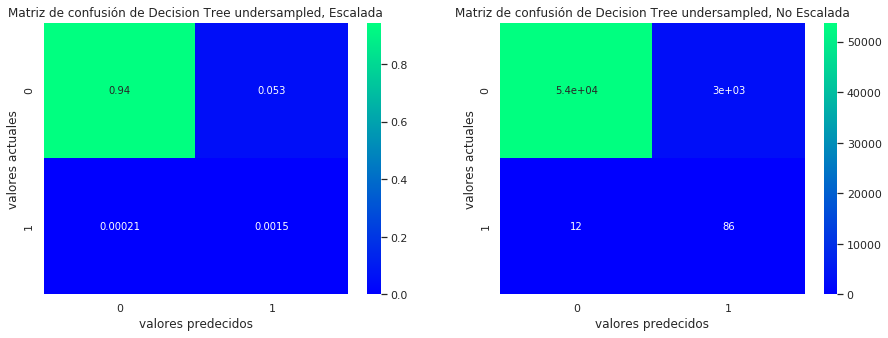

In [23]:
x_train_under, y_train_under = undersample_train_data((x_train,y_train),times=1)
tree_under_1 = DecisionTreeClassifier(
            criterion='gini',
            #min_samples_leaf=15
            max_depth=3
)


tree_under_1.fit(x_train_under,y_train_under)
fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_confusion_matrix(x_val, y_val, model=tree_under_1, scale = True,ax = axes[0])
axes[0].set_title("Matriz de confusión de {}, {}".format("Decision Tree undersampled","Escalada"))
plot_confusion_matrix(x_val, y_val, model=tree_under_1, scale = False,ax = axes[1])
axes[1].set_title("Matriz de confusión de {}, {}".format("Decision Tree undersampled","No Escalada"))
plt.show()

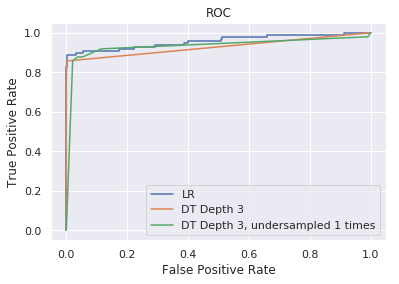

In [24]:
plot_roc_curve(t_set=(x_val,y_val), model=logistic_clf,title="ROC",label="LR")
plot_roc_curve((x_val,y_val),tree, label= "DT Depth 3")
plot_roc_curve((x_val,y_val),tree_under_1, label= "DT Depth 3, undersampled 1 times")

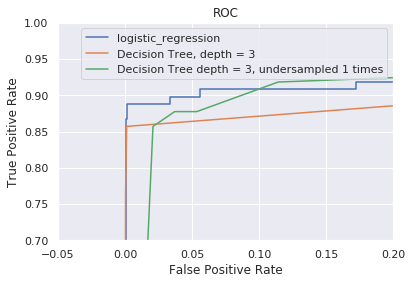

In [25]:
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=logistic_clf, 
                      title="ROC",
                      label="logistic_regression",
                      y_start=0.7
                     )
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree, 
                      title="ROC",
                      label="Decision Tree, depth = 3",
                      y_start=0.7
                     )
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree_under_1, 
                      title="ROC",
                      label="Decision Tree depth = 3, undersampled 1 times",
                      y_start=0.7
                     )

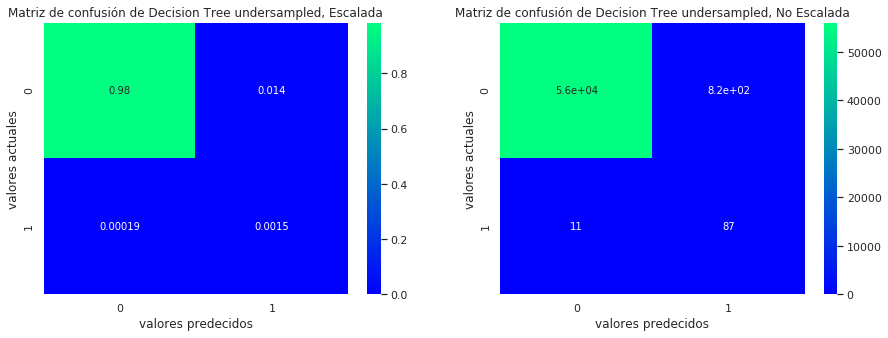

In [26]:
x_train_under,y_train_under = undersample_train_data((x_train,y_train),times=2)
tree_under_2 = DecisionTreeClassifier(
            criterion='gini',
            #min_samples_leaf=15
            max_depth=3
)
tree_under_2.fit(x_train_under,y_train_under)
fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_confusion_matrix(x_val, y_val, model=tree_under_2, scale = True,ax = axes[0])
axes[0].set_title("Matriz de confusión de {}, {}".format("Decision Tree undersampled","Escalada"))
plot_confusion_matrix(x_val, y_val, model=tree_under_2, scale = False,ax = axes[1])
axes[1].set_title("Matriz de confusión de {}, {}".format("Decision Tree undersampled","No Escalada"))
plt.show()

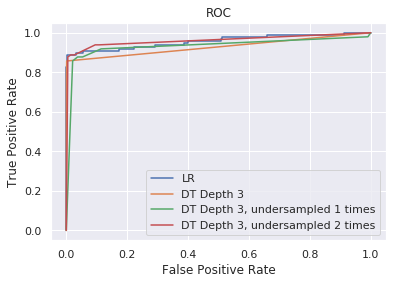

In [27]:
plot_roc_curve(t_set=(x_val,y_val), model=logistic_clf,title="ROC",label="LR")
plot_roc_curve((x_val,y_val),tree, label= "DT Depth 3")
plot_roc_curve((x_val,y_val),tree_under_1, label= "DT Depth 3, undersampled 1 times")
plot_roc_curve((x_val,y_val),tree_under_2, label= "DT Depth 3, undersampled 2 times")

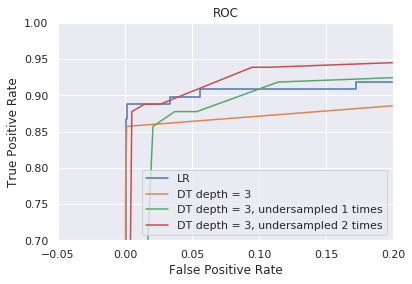

In [28]:
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=logistic_clf, 
                      title="ROC",
                      label="LR",
                      y_start=0.7
                     )
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree, 
                      title="ROC",
                      label="DT depth = 3",
                      y_start=0.7
                     )
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree_under_1, 
                      title="ROC",
                      label="DT depth = 3, undersampled 1 times",
                      y_start=0.7
                     )

plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree_under_2, 
                      title="ROC",
                      label="DT depth = 3, undersampled 2 times",
                      y_start=0.7
                     )

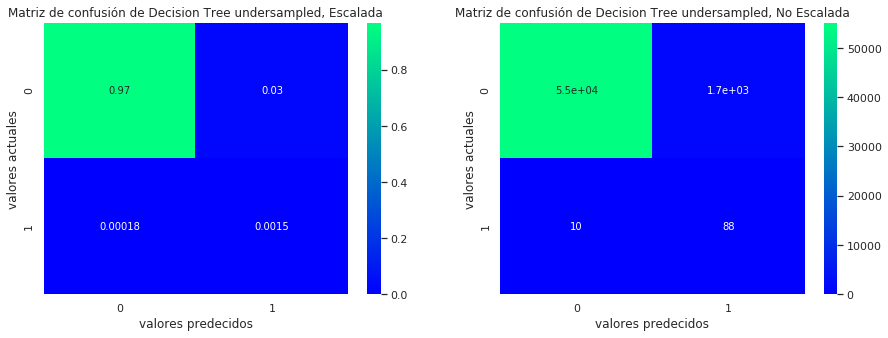

In [29]:
x_train_under,y_train_under = undersample_train_data((x_train,y_train),times=3)
tree_under_3 = DecisionTreeClassifier(
            criterion='gini',
            #min_samples_leaf=1
            max_depth=3
)
tree_under_3.fit(x_train_under,y_train_under)
fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_confusion_matrix(x_val, y_val, model=tree_under_3, scale = True,ax = axes[0])
axes[0].set_title("Matriz de confusión de {}, {}".format("Decision Tree undersampled","Escalada"))
plot_confusion_matrix(x_val, y_val, model=tree_under_3, scale = False,ax = axes[1])
axes[1].set_title("Matriz de confusión de {}, {}".format("Decision Tree undersampled","No Escalada"))
plt.show()

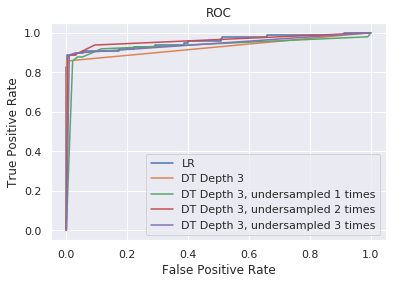

In [30]:
plot_roc_curve(t_set=(x_val,y_val), model=logistic_clf,title="ROC",label="LR")
plot_roc_curve((x_val,y_val),tree, label= "DT Depth 3")
plot_roc_curve((x_val,y_val),tree_under_1, label= "DT Depth 3, undersampled 1 times")
plot_roc_curve((x_val,y_val),tree_under_2, label= "DT Depth 3, undersampled 2 times")
plot_roc_curve((x_val,y_val),tree_under_3, label= "DT Depth 3, undersampled 3 times")

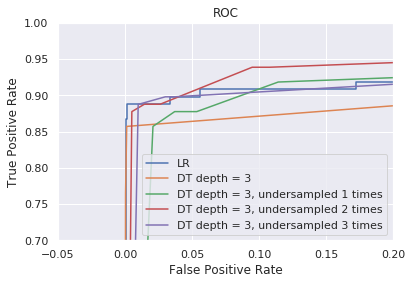

In [31]:
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=logistic_clf, 
                      title="ROC",
                      label="LR",
                      y_start=0.7
                     )
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree, 
                      title="ROC",
                      label="DT depth = 3",
                      y_start=0.7
                     )
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree_under_1, 
                      title="ROC",
                      label="DT depth = 3, undersampled 1 times",
                      y_start=0.7
                     )

plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree_under_2, 
                      title="ROC",
                      label="DT depth = 3, undersampled 2 times",
                      y_start=0.7
                     )

plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree_under_3, 
                      title="ROC",
                      label="DT depth = 3, undersampled 3 times",
                      y_start=0.7
                     )

> ¿Cómo se comparan estos modelos con el modelo con todos los datos (recuerde que las comparaciones deben hacerse calculando el desempeño sobre el conjunto de validación completo con el modelo una vez entrenado)? ¿Ve alguna ventaja en el uso de undersampling frente al uso de todos los datos?

**Comentarios:**

En general, los modelos con undersampling mejoran el rendiemiento respecto a falsos negativos (clasificados mejor lo fraudes) pero vienen con el costo de obtener un mayor índice de falsos positivos. Para el modelo que se aplico la técnica de undersampling 1 vez el rendimiento vino con una alta tasa de falsos positivos, a diferencia del modelo que se le aplico la técnica undersampling 2 veces. Este último modelo corresponde al mejor modelo un undersampling y esto se puede evidenciar en las curvas ROC, donde para una proporción de falsos positivos mayor a 0.05 empieza a tener mejor comportamiento que la regresión logística (nuestro benchmark). Finalmente el modelo que se aplicó la técnica de undersampling 3 veces tiene un rendimiento similar a la regresión logística.

Ante esto podemos ver que existe una ventaja en el uso de undersampling en el problema, si es que estamos dispuestos a tener una mayor cantidad de falsos positivos.    

#### 2.j _Oversampling_

> Otra aproximación para resolver el problema de las clases desbalanceadas es hacer _oversampling_. A partir de una muestra relativamente pequeña de ejemplos, en este caso de los casos de fraude, se busca crear un conjunto de datos más grande similar al inicial, que permita al modelo aprender las caracteristicas de esa clase, buscando nuevamente obtener clases más balanceadas que originalmente, pero esta vez sin reducir la cantidad de ejemplos. Esta aproximación tiene la ventaja que no reduce la cantidad de ejemplos pero trae la complicación de decidir cómo se van a crear los datos nuevos.

> Dos aproximaciones bastante estandar son SMOTE y ADASYN. Investigue un poco que hace SMOTE y que diferencia implemente ADASYN. Por qué cree puede ser deseable buscar que los datos sintéticos no sean linealmente dependientes de los datos originales? 

> Elija alguno de los dos métodos e impelementelo con el árbol entrenado previamente. Comente sobre el desempeño de tal modelo. 

> Note que tanto SMOTE como ADASYN tienen muchos parámetros que podrían afectar la calidad de los datos generados. No se requiere que elijan tales parametros (los por defecto bastan), pero se valorará un pequeño comentario sobre los parámetros de los métodos y qué representan en la heuristica utilizada. 

In [32]:
#!pip install  imbalanced-learn
from imblearn.over_sampling import SMOTE, ADASYN

ada = ADASYN(random_state=42)
smo = SMOTE(random_state=42)


x_tr_r, y_tr_r  = smo.fit_sample(x_train,y_train)
x_tr_r

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


array([[ 1.94674667e+00, -7.52525821e-01, -1.35512953e+00, ...,
         7.76408382e-02, -3.22477642e-02, -3.23963402e-01],
       [ 2.03514919e+00, -4.88803143e-02, -3.05869345e+00, ...,
         2.51988539e-03, -6.90016836e-02, -3.41275115e-01],
       [-9.91919644e-01,  6.03192643e-01,  7.11976018e-01, ...,
         3.80486857e-02,  1.85340320e-01,  3.46835500e-01],
       ...,
       [-1.55300958e+00,  2.07591913e+00, -3.13062114e+00, ...,
         4.66634325e-01,  3.81818649e-01, -2.43472580e-01],
       [-3.24614288e+00,  2.45476425e+00, -4.50696618e+00, ...,
        -4.99455708e-01,  9.20965992e-01, -6.25802444e-02],
       [-2.44289896e+01,  1.39781961e+01, -2.61487640e+01, ...,
         1.44049489e+00,  4.24344467e-01,  4.65392456e-02]])

In [33]:
np.unique(y_tr_r,return_counts=True)

(array([0, 1]), array([227451, 227451]))

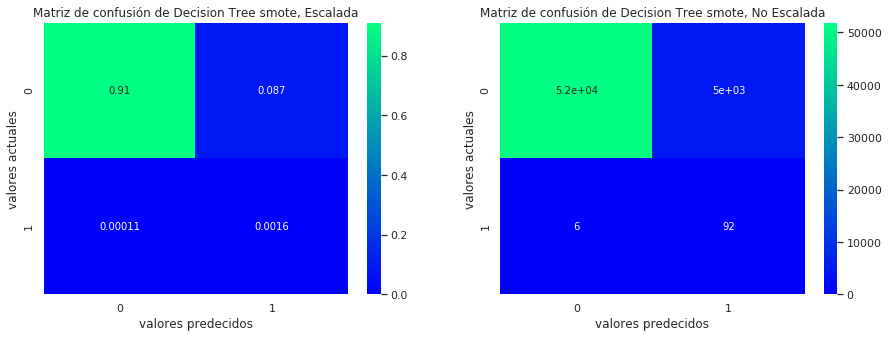

In [34]:
tree_smote = DecisionTreeClassifier(
            criterion='gini',
            #min_samples_leaf=1
            max_depth=3
)

tree_smote.fit(x_tr_r,y_tr_r)

fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_confusion_matrix(x_val, y_val, model=tree_smote, scale = True,ax = axes[0])
axes[0].set_title("Matriz de confusión de {}, {}".format("Decision Tree smote","Escalada"))
plot_confusion_matrix(x_val, y_val, model=tree_smote, scale = False,ax = axes[1])
axes[1].set_title("Matriz de confusión de {}, {}".format("Decision Tree smote","No Escalada"))
plt.show()

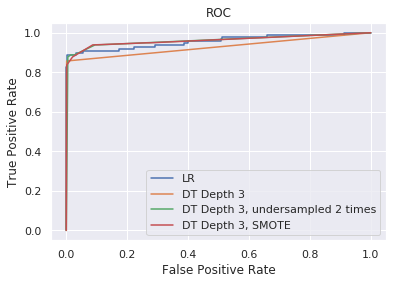

In [35]:
plot_roc_curve(t_set=(x_val,y_val), model=logistic_clf,title="ROC",label="LR")
plot_roc_curve((x_val,y_val),tree, label= "DT Depth 3")
plot_roc_curve((x_val,y_val),tree_under_2, label= "DT Depth 3, undersampled 2 times")
plot_roc_curve((x_val,y_val),tree_smote,label= "DT Depth 3, SMOTE")

In [36]:
x_tr_ada, y_tr_ada  = ada.fit_sample(x_train,y_train)


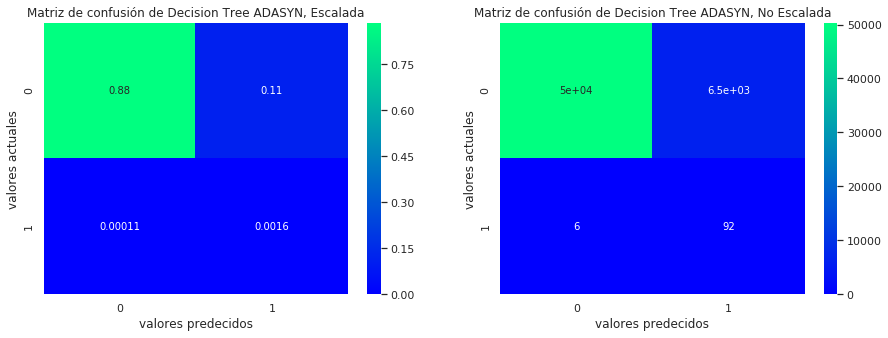

In [37]:
tree_ada = DecisionTreeClassifier(
            criterion='gini',
            #min_samples_leaf=1
            max_depth=3
)

tree_ada.fit(x_tr_ada,y_tr_ada)

fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_confusion_matrix(x_val, y_val, model=tree_ada, scale = True,ax = axes[0])
axes[0].set_title("Matriz de confusión de {}, {}".format("Decision Tree ADASYN","Escalada"))
plot_confusion_matrix(x_val, y_val, model=tree_ada, scale = False,ax = axes[1])
axes[1].set_title("Matriz de confusión de {}, {}".format("Decision Tree ADASYN","No Escalada"))
plt.show()

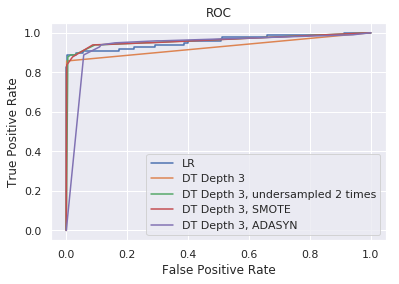

In [38]:
plot_roc_curve(t_set=(x_val,y_val), model=logistic_clf,title="ROC",label="LR")
plot_roc_curve((x_val,y_val),tree, label= "DT Depth 3")
plot_roc_curve((x_val,y_val),tree_under_2, label= "DT Depth 3, undersampled 2 times")
plot_roc_curve((x_val,y_val),tree_smote,label= "DT Depth 3, SMOTE")
plot_roc_curve((x_val,y_val),tree_ada,label= "DT Depth 3, ADASYN")

**Comentario**

- **SMOTE** funciona mediante los n-neares neighbors de la clase minoritaria, para cada muestra dentro de esta clase. Luego dibuja una línea entre los vecinos y genera puntos al azar entre estas líneas.


- **ADASYN** es una versión mejorada de SMOTE, la cual le añade pequeños valores al azar a los puntos generados con smote. En ese sentido, agrega un poco más de varianza a los puntos dispersandolos.


![](oversampling.jpeg)

Con respecto a los parámetros: 

- **SMOTE**

`SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5, m_neighbors='deprecated', out_step='deprecated', kind='deprecated', svm_estimator='deprecated', n_jobs=1, ratio=None)`
- **ADASYN**

`ADASYN(sampling_strategy='auto', random_state=None, n_neighbors=5, n_jobs=1, ratio=None)``


     - sampling_strategy: Información de muestreo para remuestrear el conjunto de datos.
     - random_state: Indica  la semilla para la randomización del algoritmo.
     - k_neighbors: Indica cuántos vecinos ocupar.
     - Parámetros deprecados: out_step, kind, svm_estimator, n_jobs, ratio.


    

> ¿Por qué cree puede ser deseable buscar que los datos sintéticos no sean linealmente dependientes de los datos originales? 

Porqué en teoría los datos generados podrían parecerse más a una distribución real. 

> Comente sobre el desempeño de tal modelo. 

SMOTE reduce la cantidad de falsos positivos con respecto a ADASYN, pero sigue siendo un número alto en comparación con el árbol co la técnica undersamplig aplicada 2 veces. Lo importante de estas técnicas es que reducen nuestra cantidad de falsos negativos a 6, siendo este el número más bajo para todos los modelos.



#### 2.k Redes neuronales _Feed Forward_ 

>Por útimo, probaremos utilizar una red neuronal densa sobre los datos aumentados. Las Redes Neuronales son una herramienta muy poderosa pero comparativamente costosa frente a otros modelos. Entrenar una red neuronal puede resultar muy costos computacionalmente, por su gran numero de parámetros entrenables y por el caracter iterativo de su entrenamiento. Además, el gran numero de parámetros hace que las redes neuronales sean particularmente sensibles al _overfitting_, por lo cual suele ser necesario tener grandes cantidades de datos para poder entrenar una red neuronal obteniendo desempeños que justifiquen su costo adicional.

>Por esto, entrenaremos la red neuronal sobre los datos aumentados. Básese en el código siguiente para crea la red neuronal. Explique los parámetros que se pasan en cada etapa de su creación, para esto puede leer la documentación de keras. Finalente, entrene "completamente" la red, es decir hasta que se estanque el error de validación o comience a aumentar. ¿Cómo se compara la red frente a otros modelos, tanto en desempeño como en costo? 

**Comentario:**

Parámetros que se pasan en cada etapa de su creación:

Lo primero que realizamos son setear las semillas para poder experimentos reproducibles con keras y que reserve la memoria que necesite (en vez de pedir toda la GPU)

```
np.random.seed(1)
tf.set_random_seed(2)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)
```

Luego en la etapa de creación del modelo tenemos `model = Sequential()`, el cual nos indica que el modelo se construira de forma secuencial. Esto quiere decir que nosotros vamos a medida que vayamos añadiendo capas al modelo (`model.add`) estas se van a ir conectando con la ultima capa de la red. 

Luego el define un modelo de 3 capas: la input layer (que esta implicita), una capa oculta, una capa de salida. El método `Dense` nos da una capa tradicional de redes neuronales, donde el primer parametro corresponde a la cantidad de neuronas en la capa, y el segundo parametro (`activation`) corresponde a la función de activación. En este caso, capa oculta tiene 256 neuronas y una funcion de activación `ReLu` (Rectified Linear Unit), y la capa de salida tiene una sola neurona (debido a que es un problema de clasificación binaria) y una funcion de activación sigmoidal (para que entregue la probabilidad de que sea o no la clase positiva).

Al momento de compilar el modelo (reservar memoria de la GPU e inicializar pesos de la red con distribucion uniforme) tenemos 3 parametros a considerar:
   - Optimizer: En este caso se esta utilizando el Stochastic Gradient Descent (SGD) y corresponde a la estrategia utilizada para realizar la operación de actualización de pesos de la red neuronal.
   - Loss: En este caso corresponde a la binary crossentropy, y este parametro corresponde a la funcion objetivo, la cual el optimizador tiene que minimizar.
   - Metrics: Esta corresponde a la medida que utilizaremos para evaluar el desempeño. En esta implementación estamos utilizando la exactitud, la cual es bastante cuestionable en problemas desbalanceados.
  
Adicionalmente nosotros definimos el Callback `EarlyStopping`, el cual nos permitira dejar de entrenar la red, si esta no esta mejorando. Para esto, tenemos que hacer seguimiento de una metrica (en este caso, utilizaremos la `val_loss`), guardando el minimo valor de esta (parametro `mode`) y dando una paciencia de 5 epochs. Esto ultimo quiere decir, a que si la val_loss no mejora en 5 epochs, terminamos el trabajo de entrenamiento, ya que posiblemente este sobreajustando. 

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Train on 227845 samples, validate on 56962 samples
Epoch 1/20
227845/227845 [==============================] - 25s 108us/step - loss: 0.0191 - acc: 0.9979 - val_loss: 0.0060 - val_acc: 0.9991
Epoch 2/20
227845/227845 [==============================] - 26s 115us/step - loss: 0.0049 - acc: 0.9992 - val_loss: 0.0048 - val_acc: 0.9993
Epoch 3/20
227845/227845 [==============================] - 30s 132us/step - loss: 0.0040 - acc: 0.9993 - val_loss: 0.0038 - val_acc: 0.9992
Epoch 4/20
227845/227845 [==============================] - 28s 123us/step - loss: 0.0037 - acc: 0.9993 - val_loss: 0.0035 - val_acc: 0.9992
Epoch 5/20
227845/227845 [==============================] - 25s 110us/step - loss: 0.0034 - acc: 0.9993 - val_loss: 0.0034 - val_acc: 0.9992
Epoch 6/20
227845/227845 [==============================] - 28s 123us/step - loss: 0.0033 - acc: 0.9994 - val_loss: 0.0032 - val_acc: 0.9993
Epoch 7/20
227845/227845 [==============================] - 28s 121us/step - loss: 0.0032 - acc: 0.9994

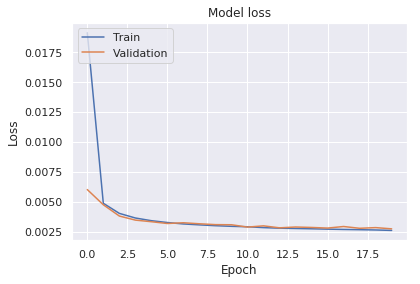

In [39]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "1"
from keras import backend as K
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(2)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)


from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping


model = Sequential()

model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history_normal = model.fit(x_train.values,y_train.values, epochs=20, validation_data=(x_val,y_val),callbacks=[es])
model.summary()

plt.plot(history_normal.history['loss'])
plt.plot(history_normal.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Train on 454909 samples, validate on 56962 samples
Epoch 1/200
454909/454909 [==============================] - 49s 109us/step - loss: 0.1170 - acc: 0.9648 - val_loss: 0.0754 - val_acc: 0.9734
Epoch 2/200
454909/454909 [==============================] - 51s 111us/step - loss: 0.0445 - acc: 0.9902 - val_loss: 0.0518 - val_acc: 0.9822
Epoch 3/200
454909/454909 [==============================] - 58s 127us/step - loss: 0.0302 - acc: 0.9930 - val_loss: 0.0373 - val_acc: 0.9877
Epoch 4/200
454909/454909 [==============================] - 51s 112us/step - loss: 0.0233 - acc: 0.9945 - val_loss: 0.0295 - val_acc: 0.9900
Epoch 5/200
454909/454909 [==============================] - 50s 110us/step - loss: 0.0191 - acc: 0.9955 - val_loss: 0.0267 - val_acc: 0.9911
Epoch 6/200
454909/454909 [==============================] - 49s 108us/step - loss: 0.0162 - acc: 0.9962 - val_loss: 0.0258 - val_acc: 0.9915
Epoch 7/200
454909/454909 [==============================] - 49s 107us/step - loss: 0.0141 - acc:

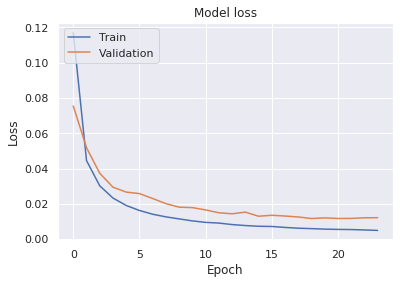

In [40]:
np.random.seed(1)
tf.set_random_seed(2)

model_ada = Sequential()

model_ada.add(Dense(256,activation='relu'))
model_ada.add(Dense(1, activation='sigmoid'))
model_ada.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history_ada = model_ada.fit(x_tr_ada,y_tr_ada, epochs=200, validation_data=(x_val,y_val),callbacks=[es])
model_ada.summary()

plt.plot(history_ada.history['loss'])
plt.plot(history_ada.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Train on 454902 samples, validate on 56962 samples
Epoch 1/200
454902/454902 [==============================] - 49s 107us/step - loss: 0.0821 - acc: 0.9686 - val_loss: 0.0520 - val_acc: 0.9851
Epoch 2/200
454902/454902 [==============================] - 47s 104us/step - loss: 0.0407 - acc: 0.9868 - val_loss: 0.0362 - val_acc: 0.9891
Epoch 3/200
454902/454902 [==============================] - 52s 115us/step - loss: 0.0288 - acc: 0.9913 - val_loss: 0.0336 - val_acc: 0.9896
Epoch 4/200
454902/454902 [==============================] - 48s 105us/step - loss: 0.0225 - acc: 0.9947 - val_loss: 0.0275 - val_acc: 0.9919
Epoch 5/200
454902/454902 [==============================] - 50s 110us/step - loss: 0.0186 - acc: 0.9962 - val_loss: 0.0227 - val_acc: 0.9937
Epoch 6/200
454902/454902 [==============================] - 48s 105us/step - loss: 0.0159 - acc: 0.9969 - val_loss: 0.0221 - val_acc: 0.9937
Epoch 7/200
454902/454902 [==============================] - 48s 105us/step - loss: 0.0139 - acc:

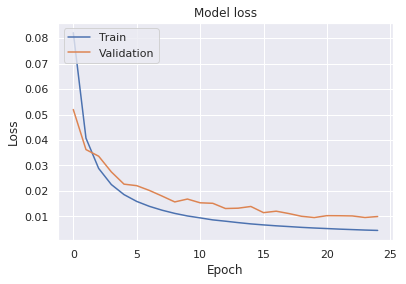

In [41]:
np.random.seed(1)
tf.set_random_seed(2)

model_smo = Sequential()

model_smo.add(Dense(256,activation='relu'))
model_smo.add(Dense(1, activation='sigmoid'))
model_smo.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history_smo = model_smo.fit(x_tr_r,y_tr_r, epochs=200, validation_data=(x_val,y_val),callbacks=[es])
model_smo.summary()

plt.plot(history_smo.history['loss'])
plt.plot(history_smo.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

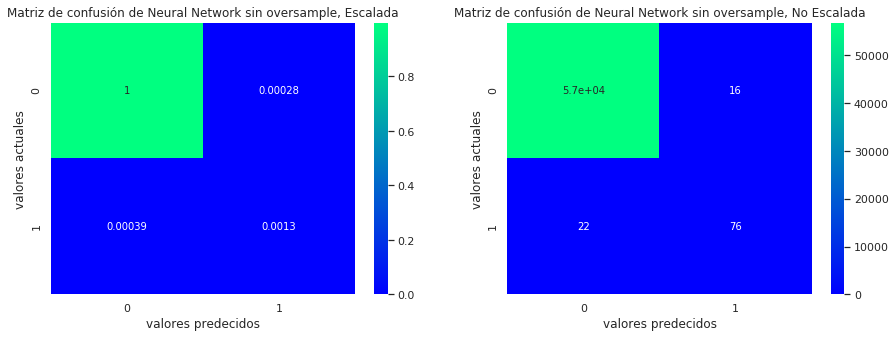

In [42]:
pred = model.predict_classes(x_val)

fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_confusion_matrix(x_val,y_val,predicted_vals=pred,scale=True,ax = axes[0])
axes[0].set_title("Matriz de confusión de {}, {}".format("Neural Network sin oversample","Escalada"))
plot_confusion_matrix(x_val,y_val,predicted_vals=pred,scale=False,ax = axes[1])
axes[1].set_title("Matriz de confusión de {}, {}".format("Neural Network sin oversample","No Escalada"))
plt.show()


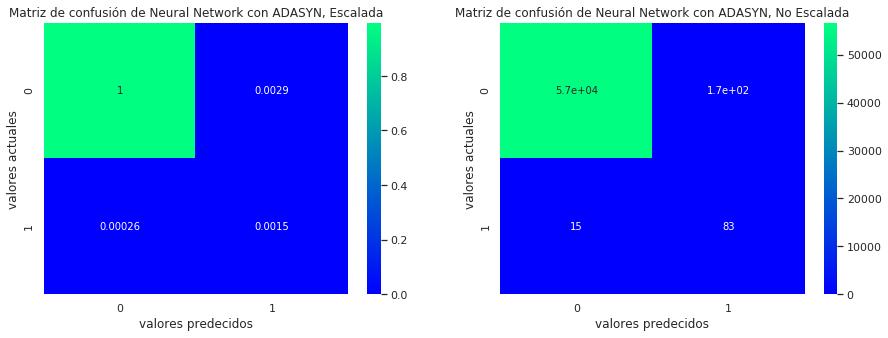

In [43]:
pred = model_ada.predict_classes(x_val)

fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_confusion_matrix(x_val,y_val,predicted_vals=pred,scale=True,ax = axes[0])
axes[0].set_title("Matriz de confusión de {}, {}".format("Neural Network con ADASYN","Escalada"))
plot_confusion_matrix(x_val,y_val,predicted_vals=pred,scale=False,ax = axes[1])
axes[1].set_title("Matriz de confusión de {}, {}".format("Neural Network con ADASYN","No Escalada"))
plt.show()

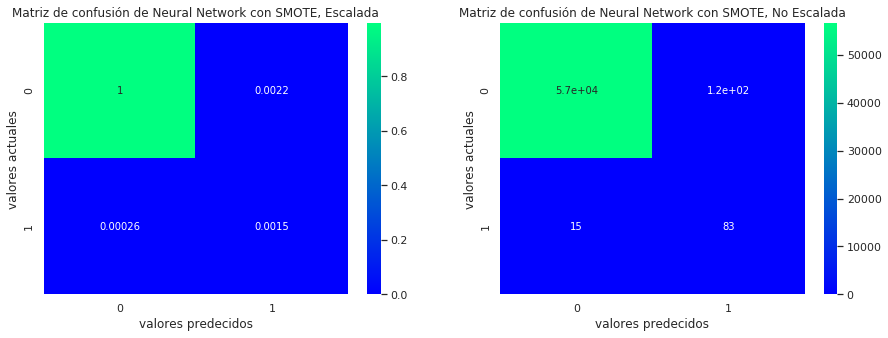

In [44]:
pred = model_smo.predict_classes(x_val)
fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_confusion_matrix(x_val,y_val,predicted_vals=pred,scale=True,ax = axes[0])
axes[0].set_title("Matriz de confusión de {}, {}".format("Neural Network con SMOTE","Escalada"))
plot_confusion_matrix(x_val,y_val,predicted_vals=pred,scale=False,ax = axes[1])
axes[1].set_title("Matriz de confusión de {}, {}".format("Neural Network con SMOTE","No Escalada"))
plt.show()

In [45]:
def plot_roc_curve_keras(t_set,model,title="ROC", label = "model"):
    x_s, y_s = t_set
    #x_vl, y_vl = val_set
    fpr, tpr, _ = roc_curve(y_s, model.predict_proba(x_s))
    plt.plot(fpr, tpr, label = label )

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    
def plot_roc_curve_zoomed_keras(t_set,model,title="ROC", label = "model",y_start = 0.8, x_end = 0.2):
    plt.xlim(-0.05, x_end)
    plt.ylim(y_start, 1)
    x_s, y_s = t_set
    #x_vl, y_vl = val_set
    fpr, tpr, _ = roc_curve(y_s, model.predict_proba(x_s))
    plt.plot(fpr, tpr, label = label )

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()

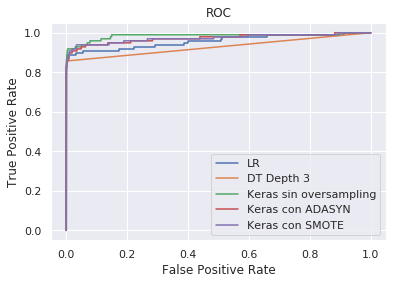

In [46]:
plot_roc_curve(t_set=(x_val,y_val), model=logistic_clf,title="ROC",label="LR")
plot_roc_curve((x_val,y_val),tree, label= "DT Depth 3")
plot_roc_curve_keras((x_val,y_val),model=model, label= "Keras sin oversampling")
plot_roc_curve_keras((x_val,y_val),model=model_ada, label= "Keras con ADASYN")
plot_roc_curve_keras((x_val,y_val),model=model_smo, label= "Keras con SMOTE")

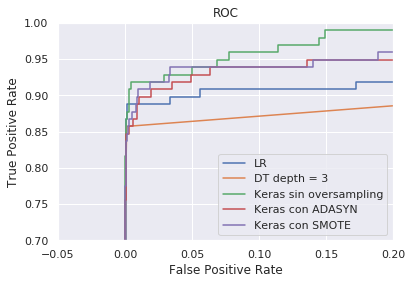

In [47]:
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=logistic_clf, 
                      title="ROC",
                      label="LR",
                      y_start=0.7
                     )
plot_roc_curve_zoomed(t_set=(x_val,y_val), 
                      model=tree, 
                      title="ROC",
                      label="DT depth = 3",
                      y_start=0.7
                     )
plot_roc_curve_zoomed_keras(t_set=(x_val,y_val), 
                      model=model, 
                      title="ROC",
                      label="Keras sin oversampling",
                      y_start=0.7
                     )
plot_roc_curve_zoomed_keras(t_set=(x_val,y_val), 
                      model=model_ada, 
                      title="ROC",
                      label="Keras con ADASYN",
                      y_start=0.7
                     )
plot_roc_curve_zoomed_keras(t_set=(x_val,y_val), 
                      model=model_smo, 
                      title="ROC",
                      label="Keras con SMOTE",
                      y_start=0.7
                     )

>¿Cómo se compara la red frente a otros modelos, tanto en desempeño como en costo? 

De acuerdo a los datos obtenidos en la matrices de confusión, la red neuronal SMOTE es la que mejor funciona en términos de falsos negativos. La red neuronal sin oversampling tiene una baja tasa de falsos positivos, pero los falsos negativos estan presentes a nivel de regresión logistica (alrededor de 20). 

En términos de costo computacional estos modelos tienen un costo mayor en la etapa de entrenamiento, pero al momento de realizar la predicción es similar a los modelos más simples.  En términos de ganancia vs costo computacional, la técnica de undersampling es mejor que  las redes neuronales en términos falsos negativos, pero tiene un peor desepeño en falsos positivos.
Es importante destacar que el tiempo extra que demora la red neuronal no justifica los resultados obtenidos en la predicción.

Dependiendo de nuestro problema, se desea minimizar ambas pero puede ser más critica una que otra.
